<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

<left><img width=25% src="img/cu_logo.svg"></left>

# Lecture 5: Supervised Learning: Linear Models for Regression and Classification

__Milton Pividori, PhD__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Announcements

* **Course evaluations**
  * Due **today**, 12/2 at midnight. But course ends on 12/12.
  * I contacted the CPBS Program Administrator.
  * Evaluations are useful.

* **Assignment 1, due today, 12/2**

* **Assignment 2** was uploaded. Due in a week (Dec 9).

# Agenda

### Part 1: Calculus Review and Gradient Descent
- Derivatives, partial derivatives, and gradients
- Gradient descent algorithm and intuition

### Part 2-3: Linear Regression
- Gradient descent for linear models
- Ordinary Least Squares (OLS) algorithm

### Part 4-6: Logistic Regression
- Classification and the logistic function
- Maximum likelihood principle
- Learning logistic regression models

### Part 7: Using Linear Models in Practice
- scikit-learn API for LinearRegression
- Statistical perspective and model assumptions

### Hands-on Exercise
- Apply regression models to real datasets

# Recall: Components of a Supervised Machine Learning Problem

To apply supervised learning, we define a dataset and a learning algorithm.

$$ \underbrace{\text{Dataset}}_\text{Features, Targets} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Predictive Model} $$

The output is a predictive model that maps inputs to targets. For instance, it can predict targets on new inputs.

# Part 1: Calculus Review

Before we present our first supervised learning algorithm, we will do a quick calculus review.

# Motivation: Optimization in ML

A machine learning algorithm typically minimizes a loss function $J$, e.g.,:

$$J(\theta)= \frac{1}{2n} \sum_{i=1}^n(y^{(i)}-\theta^\top x^{(i)})^2$$

The optimizer outputs parameters $\theta$ that best "fit" the training dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)}) \mid i = 1,2,...,n\}$.

We will use a quadratic function as our running example for an objective $J$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]

In [2]:
def quadratic_function(theta):
    """The cost function, J(theta)."""
    return 0.5*(2*theta-1)**2

We can visualize it.

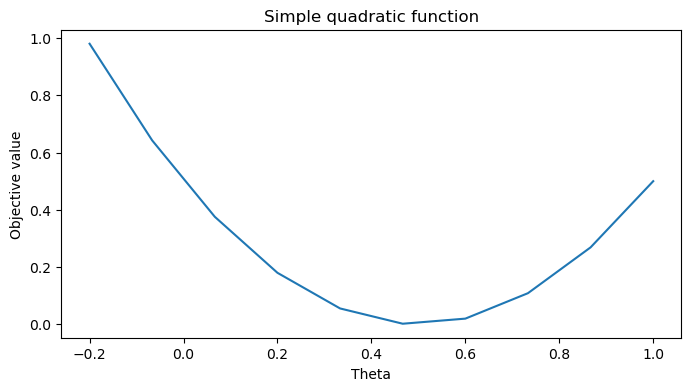

In [3]:
# First construct a grid of theta1 parameter pairs and their corresponding
# cost function values.
thetas = np.linspace(-0.2,1,10)
f_vals = quadratic_function(thetas[:,np.newaxis])

plt.plot(thetas, f_vals)
plt.xlabel('Theta')
plt.ylabel('Objective value')
plt.title('Simple quadratic function');

# Calculus Review: Derivatives

The derivative 

$$\frac{d f(\theta_0)}{d \theta}$$ 

of a univariate function $f : \mathbb{R} \to \mathbb{R}$ is the instantaneous rate of change of the function $f(\theta)$ with respect to its parameter $\theta$ at the point $\theta_0$.

In [4]:
def quadratic_derivative(theta):
    return (2*theta-1)*2

f(0) = [[0.5]]
df(0) = [[-2]]


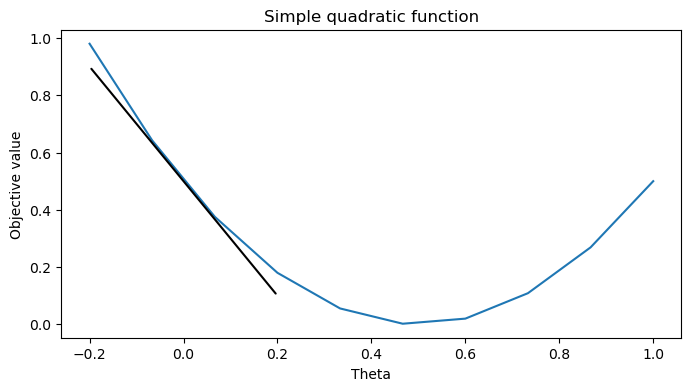

In [5]:
df0 = quadratic_derivative(np.array([[0]])) # derivative at zero
f0 = quadratic_function(np.array([[0]]))
print(f"f(0) = {f0}")
print(f"df(0) = {df0}")
line_length = 0.2

plt.plot(thetas, f_vals)
plt.annotate('', xytext=(0-line_length, f0-line_length*df0), xy=(0+line_length, f0+line_length*df0),
             arrowprops={'arrowstyle': '-', 'lw': 1.5}, va='center', ha='center')
plt.xlabel('Theta')
plt.ylabel('Objective value')
plt.title('Simple quadratic function');

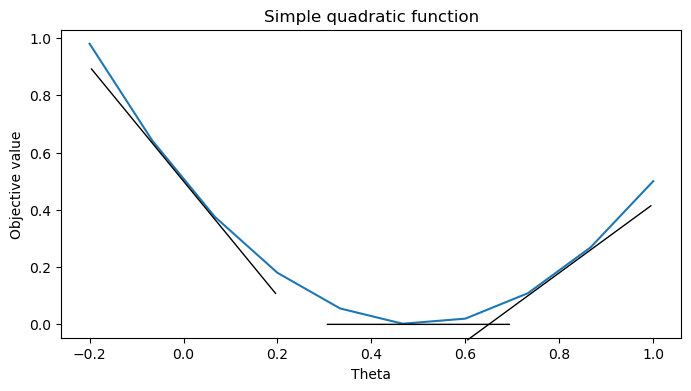

In [6]:
pts = np.array([[0, 0.5, 0.8]]).reshape((3,1))
df0s = quadratic_derivative(pts)
f0s = quadratic_function(pts)

plt.plot(thetas, f_vals)
for pt, f0, df0 in zip(pts.flatten(), f0s.flatten(), df0s.flatten()): 
    plt.annotate('', xytext=(pt-line_length, f0-line_length*df0), xy=(pt+line_length, f0+line_length*df0),
             arrowprops={'arrowstyle': '-', 'lw': 1}, va='center', ha='center')
plt.xlabel('Theta')
plt.ylabel('Objective value')
plt.title('Simple quadratic function');

# Calculus Review: Partial Derivatives

The partial derivative 

$$\frac{\partial f(\theta)}{\partial \theta_j}$$ 

of a multivariate function $f : \mathbb{R}^d \to \mathbb{R}$ is the derivative of $f$ with respect to $\theta_j$ while all the other dimensions $\theta_k$ for $k\neq j$ are fixed.

# Calculus Review: The Gradient

The gradient $\nabla f$ is the vector of all the partial derivatives:

$$ \nabla f (\theta) = \begin{bmatrix}
\frac{\partial f(\theta)}{\partial \theta_1} \\
\frac{\partial f(\theta)}{\partial \theta_2} \\
\vdots \\
\frac{\partial f(\theta)}{\partial \theta_d}
\end{bmatrix}.$$

The $j$-th entry of the vector $\nabla f (\theta)$ is the partial derivative $\frac{\partial f(\theta)}{\partial \theta_j}$ of $f$ with respect to the $j$-th component of $\theta$.

Again, we will use a quadratic function as a running example.

In [7]:
def quadratic_function2d(theta0, theta1):
    """Quadratic objective function, J(theta0, theta1).
    
    The inputs theta0, theta1 are 2d arrays and we evaluate
    the objective at each value theta0[i,j], theta1[i,j].
    We implement it this way so it's easier to plot the
    level curves of the function in 2d.

    Parameters:
    theta0 (np.array): 2d array of first parameter theta0
    theta1 (np.array): 2d array of second parameter theta1
    
    Returns:
    fvals (np.array): 2d array of objective function values
        fvals is the same dimension as theta0 and theta1.
        fvals[i,j] is the value at theta0[i,j] and theta1[i,j].
    """
    theta0 = np.atleast_2d(np.asarray(theta0))
    theta1 = np.atleast_2d(np.asarray(theta1))
    return 0.5*((2*theta1-2)**2 + (theta0-3)**2)

Let's visualize this function.

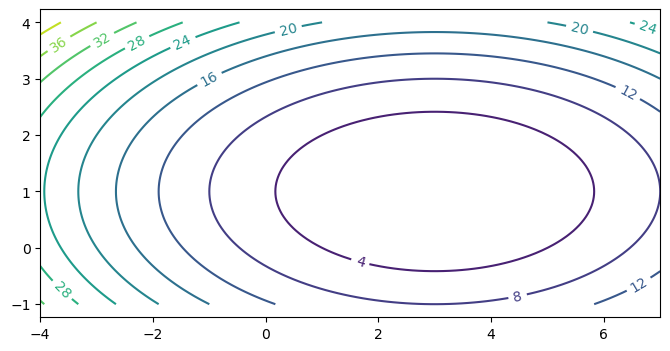

In [8]:
theta0_grid = np.linspace(-4,7,101)
theta1_grid = np.linspace(-1,4,101)
theta_grid = theta0_grid[np.newaxis,:], theta1_grid[:,np.newaxis]
J_grid = quadratic_function2d(theta0_grid[np.newaxis,:], theta1_grid[:,np.newaxis])

X, Y = np.meshgrid(theta0_grid, theta1_grid)
contours = plt.contour(X, Y, J_grid, 10)
plt.clabel(contours)
plt.axis('equal');

Let's write down the gradient of the quadratic function.

In [9]:
def quadratic_derivative2d(theta0, theta1):
    """Derivative of quadratic objective function.
    
    The inputs theta0, theta1 are 1d arrays and we evaluate
    the derivative at each value theta0[i], theta1[i].

    Parameters:
    theta0 (np.array): 1d array of first parameter theta0
    theta1 (np.array): 1d array of second parameter theta1
    
    Returns:
    grads (np.array): 2d array of partial derivatives
        grads is of the same size as theta0 and theta1
        along first dimension and of size
        two along the second dimension.
        grads[i,j] is the j-th partial derivative 
        at input theta0[i], theta1[i].
    """
    # this is the gradient of 0.5*((2*theta1-2)**2 + (theta0-3)**2)
    grads = np.stack([theta0-3, (2*theta1-2)*2], axis=1)
    grads = grads.reshape([len(theta0), 2])
    return grads

We can visualize the gradient.

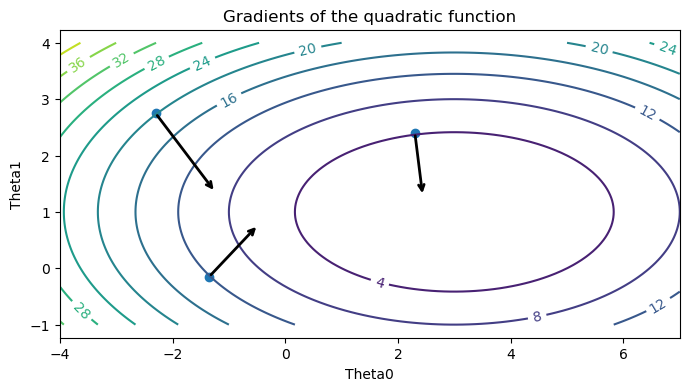

In [10]:
theta0_pts, theta1_pts = np.array([2.3, -1.35, -2.3]), np.array([2.4, -0.15, 2.75])
dfs = quadratic_derivative2d(theta0_pts, theta1_pts)
line_length = 0.2

contours = plt.contour(X, Y, J_grid, 10)
for theta0_pt, theta1_pt, df0 in zip(theta0_pts, theta1_pts, dfs):
    plt.annotate('', xytext=(theta0_pt, theta1_pt), 
                     xy=(theta0_pt-line_length*df0[0], theta1_pt-line_length*df0[1]),
                     arrowprops={'arrowstyle': '->', 'lw': 2}, va='center', ha='center')
plt.scatter(theta0_pts, theta1_pts)
plt.clabel(contours)
plt.xlabel('Theta0')
plt.ylabel('Theta1')
plt.title('Gradients of the quadratic function')
plt.axis('equal');

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 1b: Gradient Descent

Next, we will use gradients to define an important algorithm called *gradient descent*.

# Calculus Review: The Gradient

The gradient $\nabla_\theta f$ further extends the derivative to multivariate functions $f : \mathbb{R}^d \to \mathbb{R}$, and is defined at a point $\theta_0$ as

$$ \nabla_\theta f (\theta_0) = \begin{bmatrix}
\frac{\partial f(\theta_0)}{\partial \theta_1} \\
\frac{\partial f(\theta_0)}{\partial \theta_2} \\
\vdots \\
\frac{\partial f(\theta_0)}{\partial \theta_d}
\end{bmatrix}.$$

The $j$-th entry of the vector $\nabla_\theta f (\theta_0)$ is the partial derivative $\frac{\partial f(\theta_0)}{\partial \theta_j}$ of $f$ with respect to the $j$-th component of $\theta$.

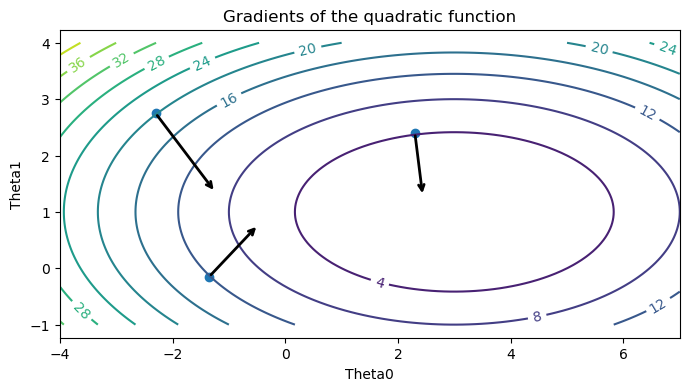

In [11]:
theta0_pts, theta1_pts = np.array([2.3, -1.35, -2.3]), np.array([2.4, -0.15, 2.75])
dfs = quadratic_derivative2d(theta0_pts, theta1_pts)
line_length = 0.2

contours = plt.contour(X, Y, J_grid, 10)
for theta0_pt, theta1_pt, df0 in zip(theta0_pts, theta1_pts, dfs):
    plt.annotate('', xytext=(theta0_pt, theta1_pt), 
                     xy=(theta0_pt-line_length*df0[0], theta1_pt-line_length*df0[1]),
                     arrowprops={'arrowstyle': '->', 'lw': 2}, va='center', ha='center')
plt.scatter(theta0_pts, theta1_pts)
plt.clabel(contours)
plt.xlabel('Theta0')
plt.ylabel('Theta1')
plt.title('Gradients of the quadratic function')
plt.axis('equal');

# Gradient Descent: Intuition

Gradient descent is a very common optimization algorithm used in machine learning.

The intuition behind gradient descent is to repeatedly obtain the gradient to determine the direction in which the function decreases most steeply and take a step in that direction.

# Gradient Descent: Notation
More formally, if we want to optimize $J(\theta)$, we start with an initial guess $\theta_0$ for the parameters and repeat the following update until $\theta$ is no longer changing:
$$ \theta_i := \theta_{i-1} - \alpha \cdot \nabla J(\theta_{i-1}). $$

In code, this method may look as follows:
```python
theta, theta_prev = random_initialization()
while norm(theta - theta_prev) > convergence_threshold:
    theta_prev = theta
    theta = theta_prev - step_size * gradient(theta_prev)
```
In the above algorithm, we stop when $||\theta_i - \theta_{i-1}||$ is small.

It's easy to implement this function in `numpy`.

In [12]:
convergence_threshold = 2e-1
step_size = 2e-1
theta, theta_prev = np.array([[-2], [3]]), np.array([[0], [0]])
opt_pts = [theta.flatten()]
opt_grads = []

while np.linalg.norm(theta - theta_prev) > convergence_threshold:
    # we repeat this while the value of the function is decreasing
    theta_prev = theta
    gradient = quadratic_derivative2d(*theta).reshape([2,1])
    theta = theta_prev - step_size * gradient
    opt_pts += [theta.flatten()]
    opt_grads += [gradient.flatten()]

We can now visualize gradient descent.

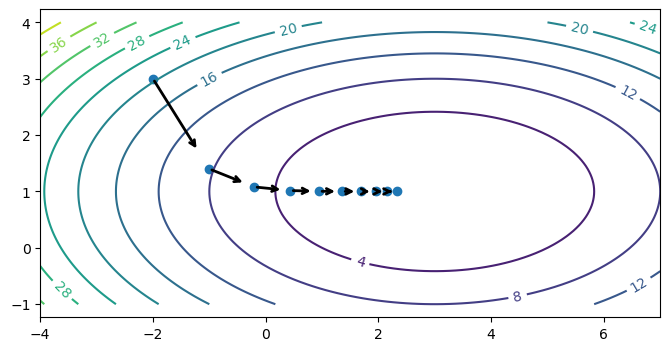

In [13]:
opt_pts = np.array(opt_pts)
opt_grads = np.array(opt_grads)

contours = plt.contour(X, Y, J_grid, 10)
plt.clabel(contours)
plt.scatter(opt_pts[:,0], opt_pts[:,1])

for opt_pt, opt_grad in zip(opt_pts, opt_grads):
    plt.annotate('', xytext=(opt_pt[0], opt_pt[1]), 
                 xy=(opt_pt[0]-0.8*step_size*opt_grad[0], opt_pt[1]-0.8*step_size*opt_grad[1]),
                 arrowprops={'arrowstyle': '->', 'lw': 2}, va='center', ha='center')

plt.axis('equal');

**Question:** What happens if the `step_size` is too small or too big?

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 2: Gradient Descent in Linear Models

Let's now use gradient descent to derive a supervised learning algorithm for linear models.

# Review: Gradient Descent
If we want to optimize $J(\theta)$, we start with an initial guess $\theta_0$ for the parameters and repeat the following update:
$$ \theta_i := \theta_{i-1} - \alpha \cdot \nabla_\theta J(\theta_{i-1}). $$

As code, this method may look as follows:
```python
theta, theta_prev = random_initialization()
while norm(theta - theta_prev) > convergence_threshold:
    theta_prev = theta
    theta = theta_prev - step_size * gradient(theta_prev)
```

# Review: Linear Model Family

A linear model has the form
\begin{align*}
y & = \theta_0 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 + ... + \theta_d \cdot x_d
\end{align*}
where $x \in \mathbb{R}^d$ is a vector of features and $y$ is the target. The $\theta_j$ are the *parameters* of the model.

By using the notation $x_0 = 1$, we can represent the model in a vectorized form
$$ f_\theta(x) = \sum_{j=0}^d \theta_j \cdot x_j = \theta^\top x. $$

Let's define our model in Python.

In [14]:
def f(X, theta):
    """The linear model we are trying to fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional data matrix
    
    Returns:
    y_pred (np.array): n-dimensional vector of predicted targets
    """
    return X.dot(theta)

# An Objective: Mean Squared Error

We pick $\theta$ to minimize the mean squared error (MSE). Slight variants of this objective are also known as the residual sum of squares (RSS) or the sum of squared residuals (SSR).
$$J(\theta)= \frac{1}{2n} \sum_{i=1}^n(y^{(i)}-\theta^\top x^{(i)})^2$$
In other words, we are looking for the best compromise in $\theta$ over all the data points.

Let's implement the mean squared error.

In [15]:
def mean_squared_error(theta, X, y):
    """The cost function, J, describing the goodness of fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    """
    return 0.5*np.mean((y-f(X, theta))**2)

**Question:** What's next if we want to minimize this function?

# Mean Squared Error: Partial Derivatives

Let's work out the derivatives for $\frac{1}{2} \left( f_\theta(x^{(i)}) - y^{(i)} \right)^2,$ the MSE of a linear model $f_\theta$ for one training example $(x^{(i)}, y^{(i)})$, which we denote $J^{(i)}(\theta)$.

\begin{align*}
\frac{\partial}{\partial \theta_j} J^{(i)}(\theta) & = \frac{\partial}{\partial \theta_j} \left(\frac{1}{2} \left( f_\theta(x^{(i)}) - y^{(i)} \right)^2\right) \\
& = \left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot \frac{\partial}{\partial \theta_j} \left( f_\theta(x^{(i)}) - y^{(i)} \right) \\
& = \left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot \frac{\partial}{\partial \theta_j} \left( \sum_{k=0}^d \theta_k \cdot x^{(i)}_k - y^{(i)} \right) \\
& = \left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}_j
\end{align*}

# Mean Squared Error: The Gradient

We can use this derivation to obtain an expression for the gradient of the MSE for a linear model

\begin{align*}
\small
{\tiny \nabla_\theta J^{(i)} (\theta)} = \begin{bmatrix}
\frac{\partial J^{(i)}(\theta)}{\partial \theta_0} \\
\frac{\partial J^{(i)}(\theta)}{\partial \theta_1} \\
\vdots \\
\frac{\partial J^{(i)}(\theta)}{\partial \theta_d}
\end{bmatrix}
=
\begin{bmatrix}
\left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}_0 \\
\left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}_1 \\
\vdots \\
\left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}_d
\end{bmatrix}
=
\left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}
\end{align*}

Note that the MSE over the entire dataset is $J(\theta) = \frac{1}{n}\sum_{i=1}^n J^{(i)}(\theta)$. Therefore:

\begin{align*}
\nabla_\theta J (\theta) = \begin{bmatrix}
\frac{\partial J(\theta)}{\partial \theta_0} \\
\frac{\partial J(\theta)}{\partial \theta_1} \\
\vdots \\
\frac{\partial J(\theta)}{\partial \theta_d}
\end{bmatrix}
=
\frac{1}{n}\sum_{i=1}^n
\begin{bmatrix}
\frac{\partial J^{(i)}(\theta)}{\partial \theta_0} \\
\frac{\partial J^{(i)}(\theta)}{\partial \theta_1} \\
\vdots \\
\frac{\partial J^{(i)}(\theta)}{\partial \theta_d}
\end{bmatrix}
=
\frac{1}{n} \sum_{i=1}^n \left( f_\theta(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}
\end{align*}

Let's implement the gradient.

In [16]:
def mse_gradient(theta, X, y):
    """The gradient of the cost function.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    
    Returns:
    grad (np.array): d-dimensional gradient of the MSE
    """
    return np.mean((f(X, theta) - y) * X.T, axis=1)

# Recall: The UCI Diabetes Dataset

In this section, we are going to again use the UCI Diabetes Dataset.
* For each patient we have a access to their BMI and an estimate of diabetes risk (from 0-400).
* We are interested in understanding how BMI affects an individual's diabetes risk.

Text(0, 0.5, 'Diabetes Risk')

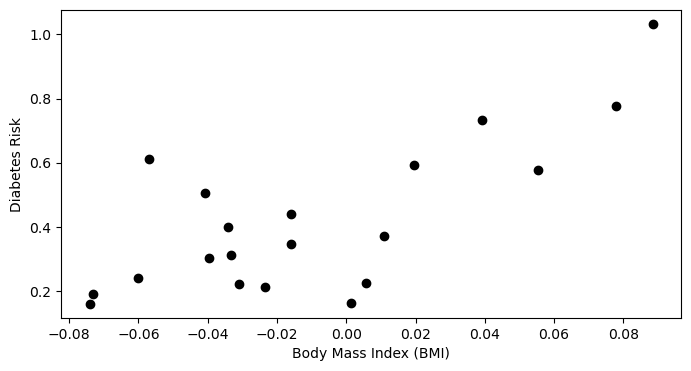

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]

import numpy as np
import pandas as pd
from sklearn import datasets

# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

# add an extra column of ones
X['one'] = 1

# Collect 20 data points and only use bmi dimension
X_train = X.iloc[-20:].loc[:, ['bmi', 'one']]
y_train = y.iloc[-20:] / 300

plt.scatter(X_train.loc[:,['bmi']], y_train,  color='black')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Diabetes Risk')

# Gradient Descent for Linear Regression

Putting this together with the gradient descent algorithm, we obtain a learning method for training linear models.


```python
theta, theta_prev = random_initialization()
while abs(J(theta) - J(theta_prev)) > conv_threshold:
    theta_prev = theta
    theta = theta_prev - step_size * (f(x, theta)-y) * x
```

This update rule is also known as the Least Mean Squares (LMS) or Widrow-Hoff learning rule.

In [18]:
threshold = 1e-3
step_size = 4e-1
theta, theta_prev = np.array([2,1]), np.ones(2,)
opt_pts = [theta]
opt_grads = []
iter_i = 0

while np.linalg.norm(theta - theta_prev) > threshold:
    if iter_i % 100 == 0:
        print('Iteration %d. MSE: %.6f' % (iter_i, mean_squared_error(theta, X_train, y_train)))
    theta_prev = theta
    gradient = mse_gradient(theta, X_train, y_train)
    theta = theta_prev - step_size * gradient
    opt_pts += [theta]
    opt_grads += [gradient]
    iter_i += 1

Iteration 0. MSE: 0.171729
Iteration 100. MSE: 0.014765
Iteration 200. MSE: 0.014349
Iteration 300. MSE: 0.013997
Iteration 400. MSE: 0.013701


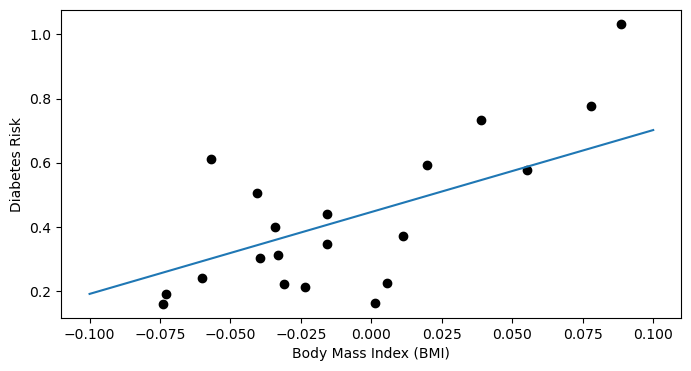

In [19]:
x_line = np.stack([np.linspace(-0.1, 0.1, 10), np.ones(10,)])
y_line = opt_pts[-1].dot(x_line)

plt.scatter(X_train.loc[:,['bmi']], y_train,  color='black')
plt.plot(x_line[0], y_line)
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Diabetes Risk');

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 3: Ordinary Least Squares

In practice, there is a more effective way than gradient descent to find linear model parameters.

This method will produce our first non-toy algorithm: Ordinary Least Squares.

# The UCI Diabetes Dataset

In this section, we are going to again use the UCI Diabetes Dataset.
* For each patient we have a access to a measurement of their body mass index (BMI) and a quantitative diabetes risk score (from 0-300). 
* We are interested in understanding how BMI affects an individual's diabetes risk.

Text(0, 0.5, 'Diabetes Risk')

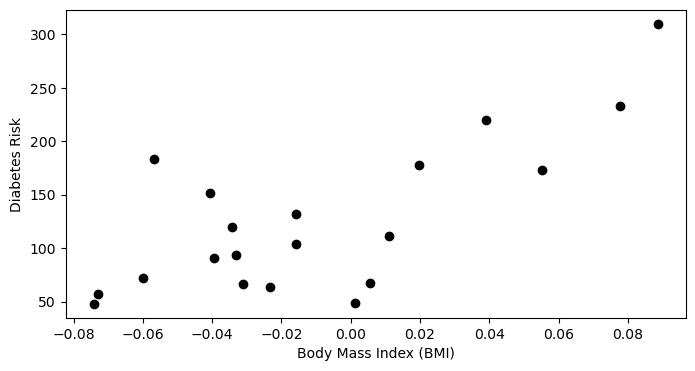

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]

import numpy as np
import pandas as pd
from sklearn import datasets

# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

# add an extra column of ones
X['one'] = 1

# Collect 20 data points
X_train = X.iloc[-20:]
y_train = y.iloc[-20:]

plt.scatter(X_train.loc[:,['bmi']], y_train,  color='black')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Diabetes Risk')

# Notation: Design Matrix

<!-- Suppose that we have a dataset of size $n$ (e.g., $n$ patients), indexed by $i=1,2,...,n$. Each $x^{(i)}$ is a vector of $d$ features. -->

Machine learning algorithms are most easily defined in the language of linear algebra. Therefore, it will be useful to represent the entire dataset as one matrix $X \in \mathbb{R}^{n \times d}$, of the form:

$$ X = \begin{bmatrix}
x^{(1)}_1 & x^{(1)}_2 & \ldots & x^{(1)}_d \\
x^{(2)}_1 & x^{(2)}_2 & \ldots & x^{(2)}_d \\
\vdots \\
x^{(n)}_1 & x^{(n)}_2 & \ldots & x^{(n)}_d
\end{bmatrix}
=
\begin{bmatrix}
- & (x^{(1)})^\top & - \\
- & (x^{(2)})^\top & - \\
& \vdots & \\
- & (x^{(n)})^\top & - \\
\end{bmatrix}
.$$

We can view the design matrix for the diabetes dataset.

In [21]:
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,one
422,-0.078165,0.050680,0.077863,0.052858,0.078236,0.064447,0.026550,-0.002592,0.040673,-0.009362,1
423,0.009016,0.050680,-0.039618,0.028758,0.038334,0.073529,-0.072854,0.108111,0.015568,-0.046641,1
424,0.001751,0.050680,0.011039,-0.019442,-0.016704,-0.003819,-0.047082,0.034309,0.024055,0.023775,1
425,-0.078165,-0.044642,-0.040696,-0.081413,-0.100638,-0.112795,0.022869,-0.076395,-0.020292,-0.050783,1
426,0.030811,0.050680,-0.034229,0.043666,0.057597,0.068831,-0.032356,0.057557,0.035459,0.085907,1


# Notation: Target Vector


Similarly, we can vectorize the target variables into a vector $y \in \mathbb{R}^n$ of the form
$$ y = \begin{bmatrix}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(n)}
\end{bmatrix}.$$

# Squared Error in Matrix Form

Recall that we may fit a linear model by choosing $\theta$ that minimizes the squared error:
$$J(\theta)=\frac{1}{2}\sum_{i=1}^n(y^{(i)}-\theta^\top x^{(i)})^2$$

We can write this sum in matrix-vector form as:
$$J(\theta) = \frac{1}{2} (y-X\theta)^\top(y-X\theta) = \frac{1}{2} \|y-X\theta\|^2,$$
where $X$ is the design matrix and $\|\cdot\|$ denotes the Euclidean norm.

# The Gradient of the Squared Error

We can compute the gradient of the mean squared error as follows.

\begin{align*}
\nabla_\theta J(\theta) 
& = \nabla_\theta \frac{1}{2} (X \theta - y)^\top  (X \theta - y) \\
& = \frac{1}{2} \nabla_\theta \left( (X \theta)^\top  (X \theta) - (X \theta)^\top y - y^\top (X \theta) + y^\top y \right) \\
& = \frac{1}{2} \nabla_\theta \left( \theta^\top  (X^\top X) \theta - 2(X \theta)^\top y \right) \\
& = \frac{1}{2} \left( 2(X^\top X) \theta - 2X^\top y \right) \\
& = (X^\top X) \theta - X^\top y
\end{align*}

We used the facts that $a^\top b = b^\top a$ (line 3), that $\nabla_x b^\top x = b$ (line 4), and that $\nabla_x x^\top A x = 2 A x$ for a symmetric matrix $A$ (line 4).

# Normal Equations

<!-- We know from calculus that a function is minimized when its derivative is set to zero. In our case, our objective function is a (multivariate) quadratic; hence it only has one minimum, which is the global minimum.
 -->
Setting the above derivative to zero, we obtain the *normal equations*:
$$ (X^\top X) \theta = X^\top y.$$

Hence, the value $\theta^*$ that minimizes this objective is given by:
$$ \theta^* = (X^\top X)^{-1} X^\top y.$$

Note that we assumed that the matrix $(X^\top X)$ is invertible.

Let's apply the normal equations.

In [22]:
import numpy as np

theta_best = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
theta_best_df = pd.DataFrame(data=theta_best[np.newaxis, :], columns=X.columns)
theta_best_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,one
0,-3.797822,204.775932,-64.275792,-263.01616,14008.122523,-11802.044811,-5893.847369,-1137.012428,-2737.876706,-394.034371,155.705025


We can now use our estimate of theta to compute predictions for 3 new data points.

In [23]:
# Collect 3 data points for testing
X_test = X.iloc[:3]
y_test = y.iloc[:3]

# generate predictions on the new patients
y_test_pred = X_test.dot(theta_best)

Let's visualize these predictions.

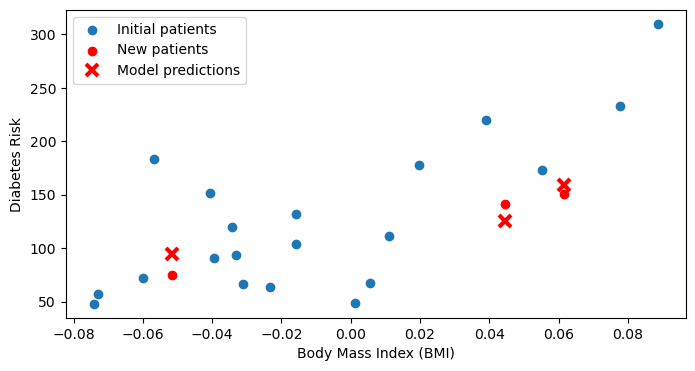

In [24]:
# visualize the results
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Diabetes Risk')
plt.scatter(X_train.loc[:, ['bmi']], y_train)
plt.scatter(X_test.loc[:, ['bmi']], y_test, color='red', marker='o')
plt.plot(X_test.loc[:, ['bmi']], y_test_pred, 'x', color='red', mew=3, markersize=8)
plt.legend(['Initial patients', 'New patients', 'Model predictions', 'New patients'])

# Algorithm: Ordinary Least Squares (OLS)

* __Type__: Supervised learning (regression)
* __Model family__: Linear models
* __Objective function__: Mean squared error
* __Optimizer__: Normal equations

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 4: Logistic Regression

Although it has "regression" in its name, Logistic Regression is a classification algorithm.

The previous algorithm, OLS, is a linear approach for regression.
Logistic Regression is a linear approach for classification.

# Classification

The previous algorithm, OLS, is a regression algorithm.

We will next look at a linear approach for classification.

# Review: Regression vs. Classification

Consider a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We distinguish between supervised learning problems depending on the targets $y^{(i)}$:

1. __Regression__: The target space is continuous: $\mathcal{Y} \subseteq \mathbb{R}$.
2. __Classification__: The target space is discrete: $\mathcal{Y} = \{y_1, y_2, \ldots y_K\}$. <br>
   <span style='color: gray'>Each of the $K$ discrete values corresponds to a *class* that we want to predict</span>

# Review: Binary Classification

An important special case of classification is when the number of classes $K=2$.

In this case, we have an instance of a *binary classification* problem.

# Review: Classifying Iris Flowers

Our running example for classification problems will be the __iris flower dataset__. 

This is a classical dataset originally published by [R. A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936. 
<!-- Nowadays, it's often used for demonstrating machine learning algorithms. -->

<center><img width=70% src="img/iris.png"/> <br>
<small style='color: gray;'>Image source: <a href="https://www.datacamp.com/tutorial/machine-learning-in-r">Machine Learning in R for Beginners</a></small></center>

Let's import the dataset from `sklearn`.

In [26]:
import warnings; warnings.filterwarnings('ignore')
from sklearn import datasets
iris = datasets.load_iris(as_frame=True)
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Below, we print out five random rows of this dataset.

In [27]:
import pandas as pd
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).sample(5) # sample 5 random rows from the data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
109,7.2,3.6,6.1,2.5,2
60,5.0,2.0,3.5,1.0,1
145,6.7,3.0,5.2,2.3,2
125,7.2,3.2,6.0,1.8,2
0,5.1,3.5,1.4,0.2,0


# Understanding Classification

How is classification different from regression?
* **Regression**: fit a curve that passes close to the targets $y^{(i)}$.
* **Classification**: find boundaries separating the classes in the feature space
* Classification model outputs often have a simple **probabilistic interpretation**: <br>
  <span style='color: gray'>they are probabilities that a data point belongs to a given class</span>

Let's look at an example on the Iris dataset. We visualize this dataset using the first 2 attributes using `matplotlib`.

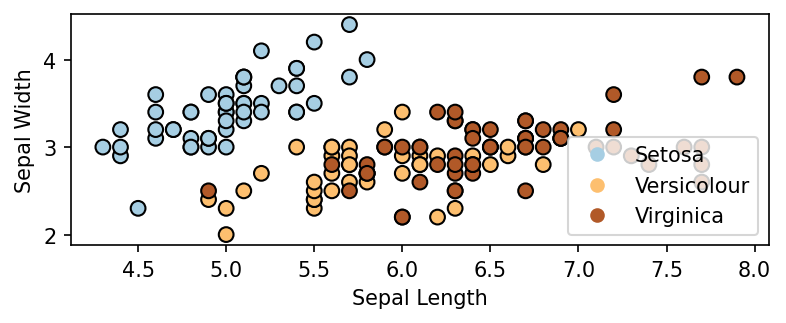

In [28]:
import matplotlib.pyplot as plt # Code from: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
plt.rcParams.update({ "figure.figsize": [6, 2], "figure.dpi": 150})
p1 = plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y, edgecolor='k', s=50, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length'); plt.ylabel('Sepal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica'], loc='lower right');

Let's train a classification algorithm called __logistic regression__.

In [29]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
X, Y = iris_X.to_numpy()[:,:2], iris_y.copy()
logreg.fit(X, Y);

Remember: logistic regression is actually a __classification__ algorithm.

The regions below are predicted to be associated with the blue, brown, and yellow classes. The lines between them are the decision boundaries.

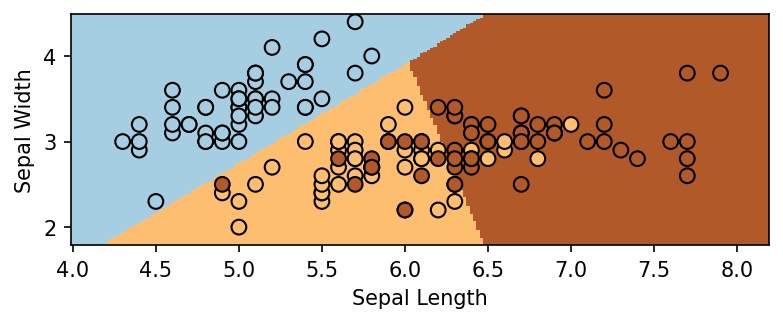

In [30]:
import numpy as np
xx, yy = np.meshgrid(np.arange(4, 8.2, .02), np.arange(1.8, 4.5, .02))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
plt.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired, s=50)
plt.xlabel('Sepal Length'); plt.ylabel('Sepal Width');

**Question**: how does this differ from a decision tree?

# How Does Logistic Regression Work?

We are now going to define how logistic regression works.

# Binary Classification 

+ We will to start by looking at __binary__ (two-class) classification. 
+ To keep things simple, we will use the Iris dataset.

We will attempt to distinguish class 0 *(Iris Setosa)* from the other two classes, using only the first two features in the dataset

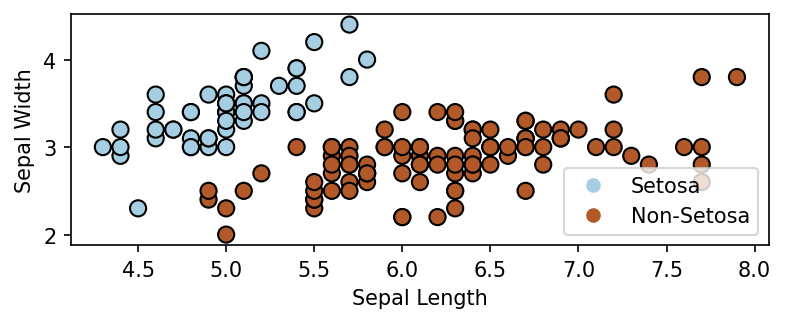

In [31]:
iris_y2 = iris_y.copy()
iris_y2[iris_y2==2] = 1  # rename class two to class one

# plot also the training points
p1 = plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y2, edgecolor='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length'); plt.ylabel('Sepal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Non-Setosa'], loc='lower right');

# Review: Ordinary Least Squares

Recall that in ordinary least squares, we fit a linear model of the form
$$ f(x) = \sum_{j=0}^d \theta_j \cdot x_j = \theta^\top x. $$

It minimizes the mean squared error (MSE)
$$J(\theta)= \frac{1}{2n} \sum_{i=1}^n(y^{(i)}-\theta^\top x^{(i)})^2$$
on a dataset $\{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We could use least squares to solve our classification problem, setting $\mathcal{Y} = \{0, 1\}$.

In [32]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
X, Y = iris_X.to_numpy()[:,:2], iris_y2
linreg.fit(X, Y);

Ordinary least squares returns a decision boundary that is not unreasonable.

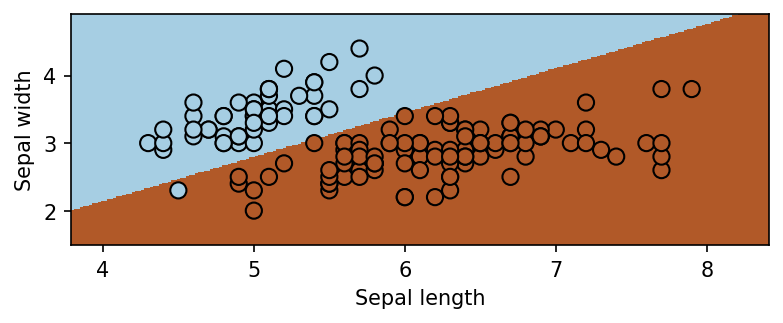

In [33]:
# Plot the decision boundary by assigning a color to each point in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = linreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z[Z>0.5] = 1.; Z[Z<0.5] = 0.

plt.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired, s=60)
plt.xlabel('Sepal length'); plt.ylabel('Sepal width');

However, applying OLS is problematic for a few reasons.
* __Unbounded outputs__: There is nothing to prevent outputs larger than one or smaller than zero, which is conceptually wrong
* __Performance issues:__ At least one point is misclassified, and others are too close to the decision boundary.

# Logistic Regression: The Model

Logistic regression is a classification algorithm where $f_\theta$ has the form
$$ f_\theta(x) = \sigma(\theta^\top x) = \frac{1}{1 + \exp(-\theta^\top x)}. $$

This is a composition of a linear model $\theta^\top x$ with 
$$ \sigma(z) = \frac{1}{1 + \exp(-z)},$$
which is the *sigmoid* or *logistic* function.

Note that logistic regression is actually a binary __classification__ algorithm.

The term *regression* is an unfortunate historical misnomer.

# The Logistic Function

To address the fact that the output of linear regression is not in $[0,1]$, we will *squeeze* it into that range using
$$ \sigma(z) = \frac{1}{1 + \exp(-z)}. $$
This is known as the *sigmoid* or *logistic* function.

The logistic function $\sigma : \mathbb{R} \to [0,1]$ "squeezes" points from the real line into $[0,1]$.

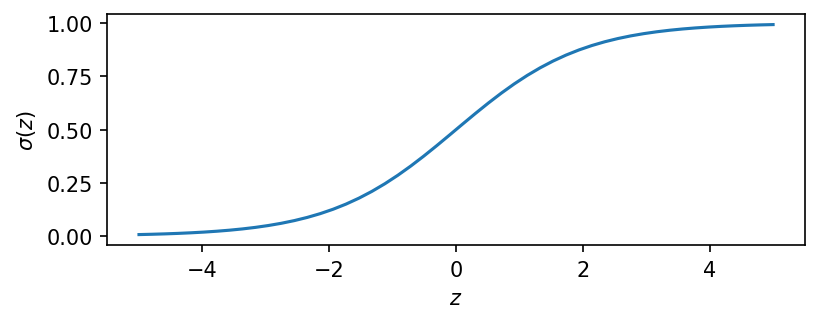

In [34]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

z = np.linspace(-5, 5)
plt.plot(z, sigmoid(z))
plt.xlabel('$z$'); plt.ylabel(r'$\sigma(z)$');

# The Logistic Function: Properties

The sigmoid function is defined as
$$ \sigma(z) = \frac{1}{1 + \exp(-z)}. $$
A few observations:

* The function tends to 1 as $z \to \infty$ and tends to 0 as $z \to -\infty$.
* Thus, models of the form $\sigma(\theta^\top x)$ output values between 0 and 1, which is suitable for binary classification.
* It is easy to show that the derivative of $\sigma(z)$ has a simple form:
$\frac{d\sigma}{dz} = \sigma(z)(1-\sigma(z)).$

# Probabilistic Interpretations

The logistic model can be interpreted to output a probability, and defines a conditional probability distribution as follows:

\begin{align*}
P_\theta(y=1 | x) & = \sigma(\theta^\top x) \\
P_\theta(y=0 | x) & = 1-\sigma(\theta^\top x).
\end{align*}

Recall that a probability over $y\in \{0,1\}$ is called Bernoulli.

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 5: Maximum Likelihood

In order to train a logistic regression model, we need to define an objective.

We derive this objective using the principle of maximum likelihood.

# Recall: Supervised Learning Models

A model is a function $f_\theta$ that maps inputs $x \in \mathcal{X}$ to targets $y \in \mathcal{Y}$.

\begin{align*}
\\
\textbf{Model Type} & & \textbf{How To Use} & & \textbf{Example} \\
f_\theta : \underbrace{\mathcal{X}}_\text{input} \to \underbrace{\mathcal{Y}}_\text{output} & & y_\text{pred} = f_\theta(x) & & y_\text{pred} = \theta^\top x \\
\\
\end{align*}


# Probabilistic Supervised Learning Models

A probabilistic model parameterizes a *probability* over $y_\text{pred}$ given $x$.

$$P_\theta(y= y_\text{pred} | x)$$

Given $x \in \mathcal{X}$, the model outputs a *conditional probability* $P(y|x)$
over targets $y \in \mathcal{Y}$.


For example, our logistic regression model $f_\theta$ defines ("parameterizes") a probability distribution $P_\theta(y|x)$ as follows:

\begin{align*}
P_\theta(y=1 | x) & = \sigma(\theta^\top x) \\
P_\theta(y=0 | x) & = 1-\sigma(\theta^\top x).
\end{align*}

For each $x$, $P_\theta(y|x)$ is a valid probability over $y \in \{0,1\}$.

This is a more general recipe for a probabilistic model:
* Given an $x$, we have __a formula for $P_\theta(y|x)$__ as a function of $x$ and $\theta$.
* The formula assigns higher probabilities ("__scores__") to more likely $y$.
* These __scores sum to 1__ over all $y$, hence they're valid probabilities.

We usually use the following notation to denote probabilistic models:

\begin{align*}
P_\theta(y|x) : \mathcal{X} \to \underbrace{(\mathcal{Y} \to [0,1])}_\text{probability $P(y|x)$ over $\mathcal{Y}$}.
\end{align*}

# Why Probabilistic Models?

There are two reasons why we will be interested in probabilistic models.

* __Confidence Estimation__: Oftentimes, we want to know if the model is certain in its prediction.
* __Learning Objective__: Probabilistic models can be used to define a principled learning objective.

# Conditional Maximum Likelihood

We can train any model that defines a probability distribution $P_\theta(y|x)$ by optimizing
the *conditional maximum likelihood* objective
$$
\max_\theta \ell(\theta) = \max_{\theta} \frac{1}{n}\sum_{i=1}^n \log P_\theta(y^{(i)} | {x}^{(i)}).
$$
defined over a dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We want to choose the weights such that the true label $y^{(i)}$ has the highest possible probability under $P_\theta(y|x^{(i)})$ for each $x^{(i)}$.

# Example: Flipping a Random Coin

$
\renewcommand{\cm}{\mathcal{M}}
$

Consider a simple example in which we repeatedly toss a biased coin and record the outcomes.

* There are two possible outcomes: heads ($H$) and tails ($T$). A training dataset consists of tosses of the biased coin, e.g., $\mathcal{D}=\{H,H,T,H,T\}$ 
* **Assumption:** true probability distribution is $P_{\textrm{data}}(y)$, $y \in \{H,T\}$ 
* Our task is to determine the probability $\theta$ of seeing heads. 

# Example: Flipping a Random Coin

How should we choose $\theta$ if 3 out of 5 tosses are heads? Let's apply maximum likelihood:

* Our dataset is $\mathcal{D}=\{y^{(1)},y^{(2)},y^{(3)},y^{(4)},y^{(5)}\}=\{H,H,T,H,T\}$ 
* Our model is $P_\theta(y)=\theta$ if $y=H$ and $P_\theta(y)=1-\theta$ if $y=T$, and there is a single parameter $\theta \in [0,1]$
* The likelihood of the data is $L(\theta) = \prod_{i=1}^n P_\theta(y^{(i)})=\theta \cdot \theta \cdot (1-\theta) \cdot \theta \cdot (1-\theta)$.

We optimize for $\theta$ which makes $\mathcal{D}$ most likely. What is the solution?

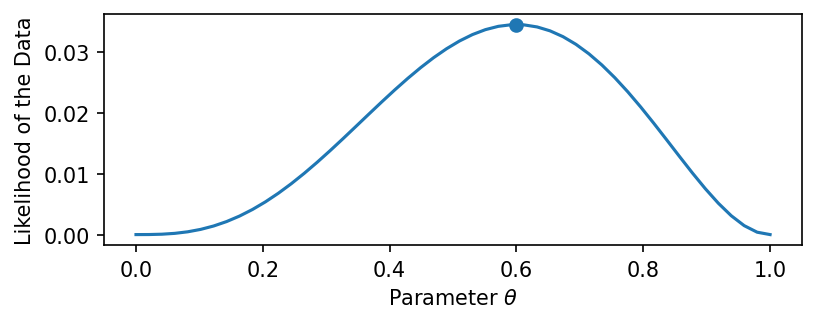

In [35]:
# our dataset is {H, H, T, H, T}; if theta = P(x=H), we get:
coin_likelihood = lambda theta: theta*theta*(1-theta)*theta*(1-theta)

theta_vals = np.linspace(0,1)
plt.ylabel('Likelihood of the Data'); plt.xlabel(r'Parameter $\theta$')
plt.scatter([0.6], [coin_likelihood(0.6)])
plt.plot(theta_vals, coin_likelihood(theta_vals));

The likelihood $L(\theta)$ is maximized by $\theta=0.6$, which is also what we expect intuitively since 3/5 tosses are heads.

<left><img width=25% src="img/cu_logo.svg"></left>


# Part 6: Learning in Logistic Regression

We will use maximum likelihood to learn the parameters of a logistic regression model.

# Logistic Regression

Recall that a logistic model defines ("parameterizes") a probability distribution $P_\theta(y|x) : \mathcal{X} \times \mathcal{Y} \to [0,1]$ as follows:

\begin{align*}
P_\theta(y=1 | x) & = \sigma(\theta^\top x) \\
P_\theta(y=0 | x) & = 1-\sigma(\theta^\top x).
\end{align*}

When $y \in \{0,1\}$, can write this more compactly as
\begin{align*}
P_\theta(y | x) = \sigma(\theta^\top x)^y \cdot (1-\sigma(\theta^\top x))^{1-y}
\end{align*}

Let's implement a logistic regression model in `numpy`.

In [36]:
def f(X, theta):
    """The sigmoid model we are trying to fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional data matrix
    
    Returns:
    y_pred (np.array): n-dimensional vector of predicted targets
    """
    return sigmoid(X.dot(theta))

# Applying Maximum Likelihood

Following the principle of maximum likelihood, we want to optimize the following objective defined over a binary classification dataset  $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

\begin{align*}
\ell(\theta) & = \frac{1}{n}\sum_{i=1}^n \log P_\theta (y^{(i)} \mid x^{(i)}) \\
& = \frac{1}{n}\sum_{i=1}^n \log \sigma(\theta^\top x^{(i)})^{y^{(i)}} \cdot (1-\sigma(\theta^\top x^{(i)}))^{1-y^{(i)}} \\
& = \frac{1}{n}\sum_{i=1}^n {y^{(i)}} \cdot \log \sigma(\theta^\top x^{(i)}) + (1-y^{(i)}) \cdot \log (1-\sigma(\theta^\top x^{(i)})).
\end{align*}

This objective is also often called the log-loss, or cross-entropy.

Observe that this objective asks the model to:
* Output a large score $\sigma(\theta^\top x^{(i)})$ (a score close to one) if $y^{(i)}=1$
* Output a score that's small (close to zero) if $y^{(i)}=0$.

\begin{align*}
\ell(\theta)
& = \frac{1}{n}\sum_{i=1}^n {y^{(i)}} \cdot \log \sigma(\theta^\top x^{(i)}) + (1-y^{(i)}) \cdot \log (1-\sigma(\theta^\top x^{(i)})).
\end{align*}

Let's implement the log-likelihood objective.

In [37]:
def log_likelihood(theta, X, y):
    """The cost function, J(theta0, theta1) describing the goodness of fit.
    
    We added the 1e-6 term in order to avoid overflow (inf and -inf).
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    """
    return (y*np.log(f(X, theta) + 1e-6) + (1-y)*np.log(1-f(X, theta) + 1e-6)).mean()

# Review: Gradient Descent
If we want to minimize an objective $J(\theta)$, we may start with an initial guess $\theta_0$ for the parameters and repeat the following update:

$$ \theta_i := \theta_{i-1} - \alpha \cdot \nabla_\theta J(\theta_{i-1}). $$

# Gradient of the Log-Likelihood

We want to use gradient descent to maximize the log-likelihood.<br>
<span style='color: gray'>Hence our objective is $J(\theta) = - \ell(\theta)$</span>

The gradient of the negative log-likelihood is
\begin{align*}
\nabla_\theta J (\theta) =  \nabla_\theta \left[-\ell (\theta) \right]= 
\frac{1}{n} \sum_{i=1}^n \left( \sigma(\theta^\top x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}
\end{align*}

Interestingly, this expression looks similar to the gradient of the mean squared error, which we derived in the previous lecture.

Let's implement the gradient.

In [38]:
def loglik_gradient(theta, X, y):
    """The cost function, J(theta0, theta1) describing the goodness of fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    
    Returns:
    grad (np.array): d-dimensional gradient of the MSE
    """
    return np.mean((f(X, theta)-y) * X.T, axis=1)

Let's now implement gradient descent.

In [39]:
threshold = 5e-5
step_size = 1e-1

theta, theta_prev = np.zeros((3,)), np.ones((3,))
opt_pts = [theta]
opt_grads = []
iter = 0
iris_X['one'] = 1
X_train = iris_X.iloc[:,[0,1,-1]].to_numpy()
y_train = iris_y2.to_numpy()

while np.linalg.norm(theta - theta_prev) > threshold:
    if iter % 50000 == 0:
        print('Iteration %d. Log-likelihood: %.6f' % (iter, log_likelihood(theta, X_train, y_train)))
    theta_prev = theta
    gradient = loglik_gradient(theta, X_train, y_train)
    theta = theta_prev - step_size * gradient
    opt_pts += [theta]
    opt_grads += [gradient]
    iter += 1

Iteration 0. Log-likelihood: -0.693145
Iteration 50000. Log-likelihood: -0.021506
Iteration 100000. Log-likelihood: -0.015329
Iteration 150000. Log-likelihood: -0.012062
Iteration 200000. Log-likelihood: -0.010076


Let's now visualize the result.

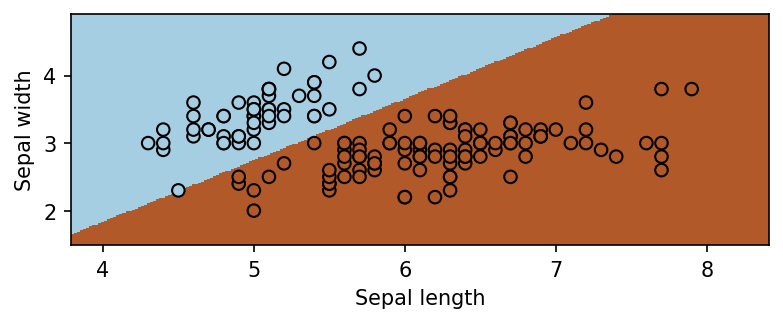

In [40]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

# predict using the learned model
Z = f(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)], theta)
Z[Z<0.5] = 0; Z[Z>=0.5] = 1

plt.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired)

plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length'); plt.ylabel('Sepal width');

**Question:** what is the probability of the labels when we approach the decision boundary?

# Observations About Logistic Regression

Logistic regression finds a linear decision boundary.

This is the set of points for which $P(y=1|x)=P(y=0|x)$. 

Equivalently:
\begin{align*}
0 = \log\frac{P(y=1|x)}{P(y=0|x)}
= \log \frac{\frac{1}{1+\exp(-\theta^\top x)}}{1-\frac{1}{1+\exp(-\theta^\top x)}}
= \theta^\top x
\end{align*}
The set of $x$ for which $0=\theta^\top x$ is a linear surface.

Unlike least squares, we don't have a closed form solution (a formula) for the optimal $\theta$. 

We can nonetheless find it numerically via gradient descent.

# Algorithm: Logistic Regression

* __Type__: Supervised learning (binary classification)
* __Model family__: Linear decision boundaries.
* __Objective function__: Cross-entropy, a special case of log-likelihood.
* __Optimizer__: Gradient descent.
* __Probabilistic interpretation__: Parametrized Bernoulli distribution.

# Multi-Class Classification

Softmax regression is an extension of logistic regression to an arbitrary number of classes.

In this lecture, we won't cover the details as we did before.

# Algorithm: Softmax Regression

* __Type__: Supervised learning (multi-class classification)
* __Model family__: Linear decision boundaries.
* __Objective function__: Softmax loss, a special case of log-likelihood.
* __Optimizer__: Gradient descent.
* __Probabilistic interpretation__: Parametrized categorical distribution.

<left><img width=25% src="img/cu_logo.svg"></left>

# Part 7: Using Linear Models with scikit-learn

We will quickly review the API of the scikit-learn for [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression).

# [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) as Simple Regression

In simple regression, we predict a target using a single feature or explanatory variable.

Let's use the UCI Diabetes Dataset.

Review:
* __Input:__ For each patient, we have access to their BMI (single feature or explanatory variable) and an estimate of diabetes risk (from 0-400, our target).
* __Output:__ We are interested in understanding how BMI affects an individual's diabetes risk.

In [41]:
import numpy as np
import pandas as pd

pd.options.display.float_format = "{:,.2f}".format
from sklearn import datasets

# We will use the UCI Diabetes Dataset
# It's a toy dataset often used to demo ML algorithms.
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True, as_frame=True)

# Use only the BMI feature
diabetes_X = diabetes_X.loc[:, ["bmi"]]

# The BMI is zero-centered and standardized; we recenter it for ease of presentation
diabetes_X = diabetes_X * 30 + 25

# Collect 20 data points
diabetes_X_train = diabetes_X.iloc[-20:]
diabetes_y_train = diabetes_y.iloc[-20:]

# Display some of the data points
pd.concat([diabetes_X_train, diabetes_y_train], axis=1).head()

,bmi,target
422,27.34,233.00
423,23.81,91.00
424,25.33,111.00
425,23.78,152.00
426,23.97,120.00


We can also visualize this two-dimensional dataset.

Text(0, 0.5, 'Diabetes Risk')

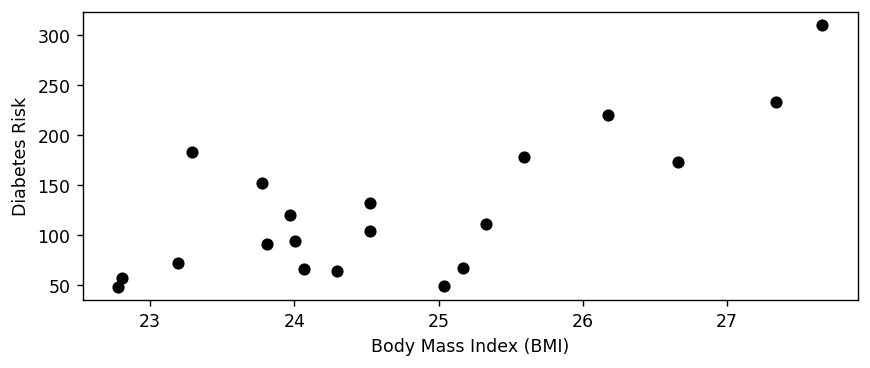

In [42]:
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": [8, 3], "figure.dpi": 125})

plt.scatter(diabetes_X_train, diabetes_y_train, color="black")
plt.xlabel("Body Mass Index (BMI)")
plt.ylabel("Diabetes Risk")

This is how we fit a `LinearRegression` estimator:

In [43]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train.values)

# Make predictions on the training set
# diabetes_y_train_pred_bmi_only = regr.predict(diabetes_X_train)

# The coefficients
print(f"Slope (theta1): {regr.coef_[0]:.2f}")
print(f"Intercept (theta0): {regr.intercept_:.2f}")

Slope (theta1): 37.38
Intercept (theta0): -797.08


**Question:** given these parameters, how does the *predictive model* look like?

Given parameters $\theta_1^*, \theta_0^*$, we define the *predictive model* as
$$ f(x) = 37.38 \cdot x - 797.08, $$
where again $x$ is the BMI, and $f(x)$ is the predicted diabetes risk score.

**Question:** how do we use this predictive model on a new sample?
$$ f(x) = 37.38 \cdot x - 797.08, $$

In [44]:
diabetes_X.iloc[[10]]

,bmi
10,22.49


In [45]:
# prediction for sample with ID 10:
# predicted_risk = 37.38 * 22.49 - 797.08
regr.coef_[0] * diabetes_X.iloc[10, 0] + regr.intercept_

np.float64(43.40946001705504)

In [46]:
# if we use the trained model, the result is the same
regr.predict(diabetes_X.iloc[[10]])

array([43.40946002])

# [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) as Multiple Regression

In multiple regression, we predict a target using multiple features or explanatory variables.

The model is similar as before, but here we have extra regression coefficients.

Let's use the UCI Diabetes Dataset again.

In [47]:
# Load the entire diabetes dataset
diabetes = datasets.load_diabetes(as_frame=True)

# Load the diabetes dataset
diabetes_X, diabetes_y = diabetes.data, diabetes.target

# Print part of the dataset
pd.concat([diabetes_X, diabetes_y], axis=1).head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.04,0.05,0.06,0.02,-0.04,-0.03,-0.04,-0.00,0.02,-0.02,151.00
1,-0.00,-0.04,-0.05,-0.03,-0.01,-0.02,0.07,-0.04,-0.07,-0.09,75.00
2,0.09,0.05,0.04,-0.01,-0.05,-0.03,-0.03,-0.00,0.00,-0.03,141.00
3,-0.09,-0.04,-0.01,-0.04,0.01,0.02,-0.04,0.03,0.02,-0.01,206.00
4,0.01,-0.04,-0.04,0.02,0.00,0.02,0.01,-0.00,-0.03,-0.05,135.00


In [48]:
# Collect 20 data points for training
diabetes_X_train = diabetes_X.iloc[-20:]
diabetes_y_train = diabetes_y.iloc[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train.values)

# Make predictions on the training set
# diabetes_y_train_pred = regr.predict(diabetes_X_train)

# The coefficients
print(f"Regression coefficients for all features (theta1+): {regr.coef_}")
print(f"Intercept (theta0): {regr.intercept_:.2f}")

Regression coefficients for all features (theta1+): [-3.79782213e+00  2.04775932e+02 -6.42757925e+01 -2.63016160e+02
  1.40081225e+04 -1.18020448e+04 -5.89384737e+03 -1.13701243e+03
 -2.73787671e+03 -3.94034371e+02]
Intercept (theta0): 155.71


Interpretation of the regression coefficients:
* $\theta_0$ is the mean value of the target $y$ when all the features (or explanatory variables) are equal to zero.
* $\theta_{j} (j \neq 0)$ is the mean change in $y$ when the $j$th feature increases by 1 unit and the other features are held constant.

* In the course, we use the asterisk to refer to "estimated values":
  * $\theta_{1}^*$, for example, is our estimated regression coefficient for feature $1$, and it represents the *estimated* mean change in $y$ when the feature $1$ increases by 1 unit and the other features are held constant.

**Question:** given these parameters, how does the *predictive model* look like?

Given parameters $\theta_0^*, \theta_1^*\ldots\theta_{10}^*$, we define the *predictive model* as
$$ f(x) = -3.79 \cdot x_1 + 204.78 \cdot x_2 \ldots + 155.71, $$
where $x_1$ is age, $x_2$ is sex, etc (same order as columns in `diabetes_X_train`) and $f(x)$ is the predicted diabetes risk score.

**Question:** how do we use this predictive model on a new sample?

In [49]:
diabetes_X.iloc[[10]]

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
10,-0.10,-0.04,-0.08,0.01,-0.10,-0.09,-0.01,-0.08,-0.06,-0.03


In [50]:
# prediction for sample with ID 10:
(regr.coef_ @ diabetes_X.iloc[10]) + regr.intercept_

np.float64(125.50805902967093)

In [51]:
# if we use the trained model, the result is the same
regr.predict(diabetes_X.iloc[[10]])

array([125.50805903])

# Linear Models with a Statistical Perspective

So far, we approached these models from a **machine learning perspective**: we want to use features to predict targets.

We can also approach them from a **statistical perspective**: we want to compute associations between individual features with the target, obtain a p-value for each coefficient, and confidence intervals.

In **genome-wide association studies (GWAS)**, for example, we train a regression model to **compute an association** between a single nucleotide polymorphism (SNP) and a disease or trait.

This is accomplished by training a *multiple regression model* where:
* The *target* is either 1) a binary vector representing disease cases and controls (ones and zeros), 2) a numerical vector representing some trait (such as height).
* The features are a SNP (a single point mutation in the genome) and different "covariates" used to control for potential confounders or effects we are not interested in, such as ancenstry, sex, age, etc.

**Question:** if we are interested in using GWAS to detect genetic risk factors for a disease, what type of model would we use? what if the target is a trait like LDL cholesterol levels?

If your problem requires this **statistical perspective**, you would use the package [`statsmodels`](https://www.statsmodels.org/stable/index.html) in Python, not `scikit-learn` (more ML oriented).

The **hands-on exercise** contain code, examples and slides from the previous year, which are focused more on a **statistical perspective** of all these models.

# Hypothesis testing for individual regression coefficients

$H_0: \beta_i = 0$

($\beta_i$ here are our previous $\theta_i$)

**Null hypothesis**: There is no linear association between the explanatory variable (or feature) $i$ and the outcome (or target) when the other explanatory variables are held constant.

---

$H_1: \beta_i \neq 0$

**Alternative hypothesis**: There is an association between the explanatory variable $i$ and the outcome when the other explanatory variables are held constant.

# Linear Regression Assumptions

* **Linearity**: The relationship between the mean response and the explanatory variables is linear in the explanatory variables.

* **About the errors**:
   * The errors are assumed to follow a normal distribution.
   * The errors have a mean of zero.
   * The errors have constant variance (homoscedasticity or homogeneity of variance).
   * The errors are independent of one another.

* **About explanatory variables:**
   * The explanatory variables are nonrandom (fixed).
   * The explanatory variables are not highly correlated with one another.

* **About observations:** All observations are equally reliable and have approximately equal role in determining the regression results in influencing conclusions.

# Model Selection

If we have several explanatory variables, there are many models we may potentially fit. How do we choose which one is best?

There is no best approach. In general, we want the simplest model that adequately explains the data, e.g., the most parsimonious model.

Below we briefly mention some **stepwise variable selection methods**.

# Backward Selection

* Start with all variables and drop one variable at a time.
* The variable with the largest p-value is considered for removal. The variable is removed if it is not significant, and a new model (excluding that variable) is fit.
* Variables are removed in this way until all variables in the model are significant.

# Forward Selection

* Start with only an **intercept** in the model.
* Look for the **first variable**: the most associated one with the response variable (via correlation analysis or simple regression). If this regression coefficient is significantly different from zero a search for a second variable is made.
* The **next variable** selected is the most highly correlated with the residuals (i.e., the leftover variation not explained by the current model) from the model with the first explanatory variable. If this regression coefficient is significantly different from zero, a search for a third regression variable is made.
* This process continues **until there are no additional variables** that are significantly different from zero.

# **Hands-on**: Regression Examples

* Open file `lecture05-Python-hands_on-solved.ipynb` or `lecture05-R-hands_on-solved.ipynb` and follow the instructions there.
* These exercises also contain extra material, where the linear models discussed today are presented more from a statistical perspective.
* They have code relevant for Assignment 2.

# Anonymous Feedback On This Lecture

<center>
    <img width=60% src="img/feedback_form_qr.png">
</center>

* **Link:** https://forms.office.com/r/prXY35CNuz
* **Lecture number:** 5
* **Lecture topic:** linear models